In [1]:
import numpy as np
import pandas as pd
import pickle as pckl
import torch as torch
from torch import nn as nn
from torch import optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
df = pd.read_csv('data_fixed.csv', delimiter = ';')
df['Timestamp'] = pd.to_datetime(df['Timestamp']) 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def fix_timeseries(df):
    df_new = df.copy()

    df_new['hour'] = df['Timestamp'].dt.hour
    df_new['minute'] = df['Timestamp'].dt.minute
    df_new['second'] = df['Timestamp'].dt.second

    df_new['sin_h'] = np.sin(2* np.pi * df_new['hour']/24)
    df_new['cos_h'] = np.cos(2* np.pi * df_new['hour']/24)
    df_new['sin_m'] = np.sin(2* np.pi * df_new['minute']/60)
    df_new['cos_m'] = np.cos(2* np.pi * df_new['minute']/60)
    df_new['sin_s'] = np.sin(2* np.pi * df_new['second']/60)
    df_new['cos_s'] = np.cos(2* np.pi * df_new['second']/60)
    
    return df_new

In [6]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [12]:
def prep_data(df, seq_length,batch_size = 50):
    df_copy = df.copy()
    
    df_with_time = fix_timeseries(df_copy)
    timestamps = df_with_time['Timestamp'].values
    
    numeric_df = df_with_time.copy()
    error_values = ['#NAMN', '#NAMN?', '#NAME?', '#DIV/0!', '#N/A', '#NULL!', '#NUM!', '#REF!', '#VALUE!']
    
    for col in numeric_df.columns:
        if numeric_df[col].dtype == 'object' or numeric_df[col].astype(str).str.contains('#').any():
            numeric_df[col] = numeric_df[col].astype(str).replace(error_values, '1e9')
            numeric_df[col] = pd.to_numeric(numeric_df[col], errors='coerce')
    
    for col in numeric_df.columns:
        if pd.api.types.is_numeric_dtype(numeric_df[col]):
            valid_values = numeric_df[col][~np.isinf(numeric_df[col])]
            if len(valid_values) > 0:
                max_value = valid_values.max()
                numeric_df[col] = numeric_df[col].replace([np.inf, -np.inf], max_value)
    
    numeric_df = numeric_df.fillna(numeric_df.mean(numeric_only=True))
    numeric_df = numeric_df.drop(['Timestamp', 'hour', 'minute', 'second'], axis=1, errors='ignore')
    
    feature_names = numeric_df.columns.tolist()
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(numeric_df)
    
    
    X, y = create_sequences(data_scaled, seq_length)
    
    
    test_ratio = 0.2
    train_size = int((1 - test_ratio) * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.FloatTensor(y_test).to(device)
    
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, timestamps,feature_names,test_loader, scaler

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        # x shape: (batch_size, seq_length, input_size)
        out, _ = self.lstm(x, (h0, c0)) 
        
        out = self.fc(out[:, -1, :])
        return out

In [14]:
def train_lstm_model(epochs, model, train_loader, test_loader=None, weight_decay=1e-4, early_stop_patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    
    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")
        
        
        if test_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
            
            
            val_loss = val_loss / len(test_loader)
            val_losses.append(val_loss)
            print(f"Validation Loss: {val_loss:.6f}")
            
            
            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
                best_model_state = model.state_dict().copy()
                print(f"New best model saved with validation loss: {best_loss:.6f}")
            else:
                patience_counter += 1
                print(f"Early stopping patience: {patience_counter}/{early_stop_patience}")
                if patience_counter >= early_stop_patience:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                    if best_model_state is not None:
                        model.load_state_dict(best_model_state)
                    break
    
    if test_loader is not None and best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses if test_loader is not None else None
    }
    
    return model, history

In [15]:
seq_length = 20
input_size = 12 
hidden_size = 64
num_layers = 2
output_size = 12  
batch_size = 50
epochs = 100

In [16]:
train_loader, timestamps,feature_names,test_loader, scaler= prep_data(df, seq_length,batch_size)

In [17]:
model = LSTM(input_size, hidden_size, num_layers,output_size)

In [18]:
trained_model,history = train_lstm_model(epochs, model, train_loader, test_loader)

Epoch 1/100, Train Loss: 0.392879
Validation Loss: 0.721735
New best model saved with validation loss: 0.721735
Epoch 2/100, Train Loss: 0.125868
Validation Loss: 0.628858
New best model saved with validation loss: 0.628858
Epoch 3/100, Train Loss: 0.046404
Validation Loss: 0.495230
New best model saved with validation loss: 0.495230
Epoch 4/100, Train Loss: 0.029399
Validation Loss: 0.468563
New best model saved with validation loss: 0.468563
Epoch 5/100, Train Loss: 0.021660
Validation Loss: 0.459668
New best model saved with validation loss: 0.459668
Epoch 6/100, Train Loss: 0.017833
Validation Loss: 0.454624
New best model saved with validation loss: 0.454624
Epoch 7/100, Train Loss: 0.015634
Validation Loss: 0.449602
New best model saved with validation loss: 0.449602
Epoch 8/100, Train Loss: 0.014084
Validation Loss: 0.447358
New best model saved with validation loss: 0.447358
Epoch 9/100, Train Loss: 0.013055
Validation Loss: 0.444553
New best model saved with validation loss: 0

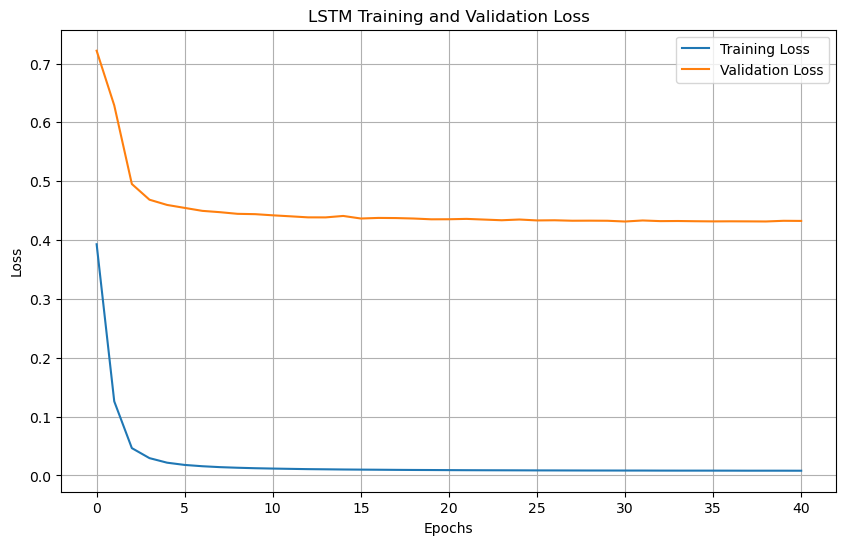

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
if history['val_loss'] is not None:
    plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
torch.save(trained_model.state_dict(),'LSTM.pth' )
joblib.dump(scaler,'LSTMscaler.sav')

['LSTMscaler.sav']